# 2일차 - 25년 7월 5일

- 완전연결 신경망(Fully-connected net) 구조를 직접 코드로 구성
- 예시 데이터는 sklearn.datasets의 분류용 데이터 사용 (make_classification)-


Epoch 5/30, Loss: 0.8756
Epoch 10/30, Loss: 0.5895
Epoch 15/30, Loss: 0.4354
Epoch 20/30, Loss: 0.3558
Epoch 25/30, Loss: 0.3059
Epoch 30/30, Loss: 0.2593
✅ Test Accuracy: 84.50%


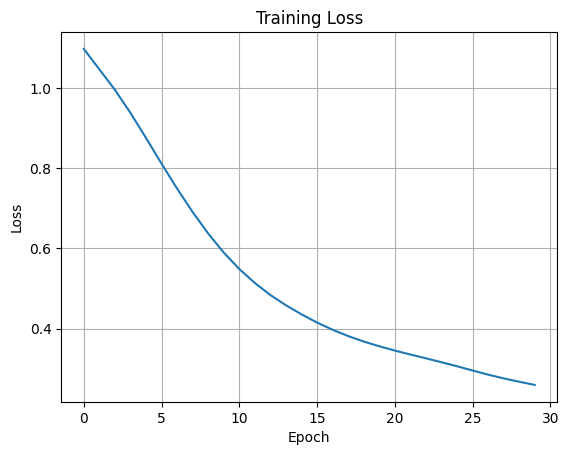

In [3]:
# 📌 1. 기본 설정
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# 데이터 생성
X, y = make_classification(n_samples=1000, n_features=10, n_classes=3, n_informative=5, random_state=42)

# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Tensor 변환
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


# 📌 2. DNN 모델 정의 (입력 → 은닉층2개 → softmax)

class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(10, 64)     # 입력: 10차원
        self.fc2 = nn.Linear(64, 32)     # 은닉층1
        self.out = nn.Linear(32, 3)      # 출력: 클래스 3개

    def forward(self, x):
        x = F.relu(self.fc1(x))          # h(1) = ReLU(W1·x)
        x = F.relu(self.fc2(x))          # h(2) = ReLU(W2·h1)
        x = self.out(x)                  # W3·h2
        return F.log_softmax(x, dim=1)   # softmax(W3·h2)

model = SimpleDNN()

# 📌 3. 학습 루프 정의

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

epochs = 30
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 📌 4. 테스트 정확도 확인

model.eval()
with torch.no_grad():
    pred = model(X_test).argmax(dim=1)
    accuracy = (pred == y_test).float().mean()
    print(f"✅ Test Accuracy: {accuracy.item():.2%}")


# 📌 5. 학습 그래프 시각화

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

## Adversarial Attack (FGSM) 예제

- pyTorch 기반 **MNIST 숫자 분류 모델에 적대적 공격(FGSM)** 적용

- 먼저 설치

```bash
pip install torch torchvision matplotlib
```

### ✅ 결과
- 원래는 맞게 예측되던 이미지가, FGSM 공격 후 잘못된 숫자로 분류됨
- 눈엔 거의 동일하지만 AI는 오답으로 판단함 → 이게 Adversarial Attack

In [8]:
# 📌 1. 라이브러리 로딩 및 MNIST 데이터 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📌 2. 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10 * 12 * 12, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 10 * 12 * 12)
        x = self.fc1(x)
        return x

model = SimpleCNN().to(device)

# 사전 학습된 모델이 없으므로 학습은 생략 (빠르게 테스트만 할 예정)


# 📌 3. FGSM 공격 함수 정의
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

# 📌 4. 테스트 + 공격 시도 (한 장의 이미지로 시연)
import torch.nn.functional as F

# 손실 함수
loss_fn = nn.CrossEntropyLoss()

# 모델 평가 모드
model.eval()

# 테스트 이미지 1장만
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 그래디언트 추적 켜기
images.requires_grad = True

# 예측
output = model(images)
init_pred = output.max(1, keepdim=True)[1]

if init_pred.item() == labels.item():
    loss = loss_fn(output, labels)
    model.zero_grad()
    loss.backward()

    # 공격 적용
    epsilon = 0.3
    data_grad = images.grad.data
    perturbed_image = fgsm_attack(images, epsilon, data_grad)

    # 다시 예측
    output_adv = model(perturbed_image)
    final_pred = output_adv.max(1, keepdim=True)[1]

    print(f"🧾 원래 예측: {init_pred.item()}, 공격 후 예측: {final_pred.item()}")

    # 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(images.squeeze().detach().cpu().numpy(), cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title("Adversarial Image")
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()
else:
    print("초기 예측부터 틀려서 공격 테스트 생략됨.")

초기 예측부터 틀려서 공격 테스트 생략됨.


### Uncertainty Quantification (UQ) 실습 예시

- 의료 이미지 예시로 구조 짜기



In [11]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# softmax 후 엔트로피 계산 함수
def entropy(probs):
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=1)

# 예측 및 불확실성 측정
def predict_with_uncertainty(model, x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        ent = entropy(probs)
    return probs, ent

# 불확실성이 높은 샘플만 필터링
def filter_uncertain_samples(inputs, entropy_values, threshold=1.0):
    uncertain_idxs = (entropy_values > threshold).nonzero(as_tuple=True)[0]
    return inputs[uncertain_idxs], entropy_values[uncertain_idxs]

## 리뷰 (2025년 7월 4일)

--


L2 Norm: 5.0
L1 Norm: 7
L∞ Norm: 4


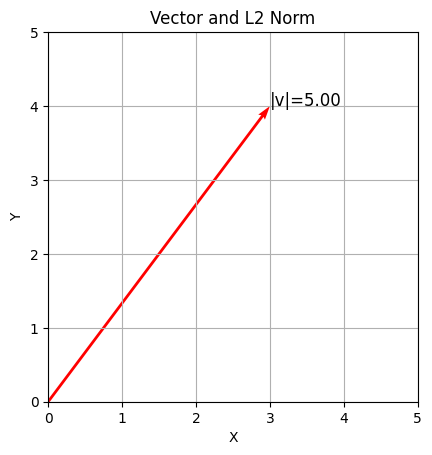

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 벡터 정의
v = np.array([3, 4])

# L2 Norm (유클리디안 노름)
l2_norm = np.linalg.norm(v)

# L1 Norm (맨해튼 노름)
l1_norm = np.sum(np.abs(v))

# L∞ Norm (최댓값 노름)
linf_norm = np.max(np.abs(v))

# 결과 출력
print(f"L2 Norm: {l2_norm}")
print(f"L1 Norm: {l1_norm}")
print(f"L∞ Norm: {linf_norm}")

# 시각화
origin = [0], [0]
plt.quiver(*origin, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='r')
plt.text(v[0], v[1], f"|v|={l2_norm:.2f}", fontsize=12)

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Vector and L2 Norm")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

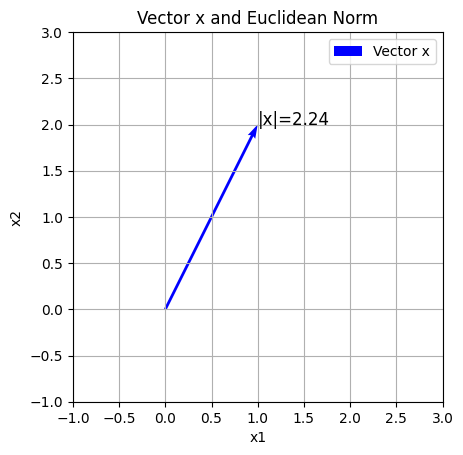

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 벡터 정의
x = np.array([1, 2])

# L2 Norm (Euclidean norm)
l2_norm = np.linalg.norm(x)

# 시각화
origin = [0], [0]
plt.quiver(*origin, x[0], x[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Vector x')

# 벡터의 끝에 라벨 추가
plt.text(x[0], x[1], f"|x|={l2_norm:.2f}", fontsize=12, color='black', ha='left')

plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.title("Vector x and Euclidean Norm")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

### Vector와 Norm
- L1, L2 비교작업

1. 📍 L2-Norm (Euclidean Norm, 유클리드 노름)
	- 수식:
\|x\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}
	- 예시로 x = [1, 2]일 때:
\|x\|_2 = \sqrt{1^2 + 2^2} = \sqrt{5} \approx 2.24
	- 이것은 벡터의 **직선 거리(대각선 길이)**를 의미합니다.
2. 📍 L1-Norm (Manhattan Norm, 맨해튼 노름)
	 - 수식:
\|x\|_1 = |x_1| + |x_2| + \cdots + |x_d|
	- 예시로 x = [1, 2]일 때:
\|x\|_1 = |1| + |2| = 3
	 - 이것은 격자 도시(맨해튼)에서의 직각 경로 거리를 뜻합니다.

> Norm은 피타고라스 거리
> L1 Norm은 **계단식 거리 (택시 거리)**입니다

L2 Norm (Euclidean): 2.236
L1 Norm (Manhattan): 3.000


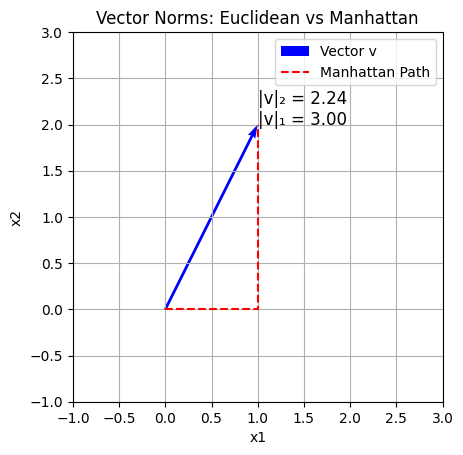

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# 벡터 정의
v = np.array([1, 2])

# Norm 계산
l2 = np.linalg.norm(v, ord=2)
l1 = np.linalg.norm(v, ord=1)

print(f"L2 Norm (Euclidean): {l2:.3f}")
print(f"L1 Norm (Manhattan): {l1:.3f}")

# 시각화
origin = [0], [0]

plt.quiver(*origin, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Vector v')
plt.text(v[0], v[1], f"|v|₂ = {l2:.2f}\n|v|₁ = {l1:.2f}", fontsize=12)

# 격자 기준선 추가
plt.plot([0, v[0], v[0]], [0, 0, v[1]], 'r--', label='Manhattan Path')

plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.title("Vector Norms: Euclidean vs Manhattan")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()